In [2]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import sklearn.cluster as sl
import torch
import matplotlib.pyplot as plt

In [3]:
def sqrtinvdiag(M):
    """Inverts and square-roots a positive diagonal matrix.
    Args:
        M (csc matrix): matrix to invert
    Returns:
        scipy sparse matrix of inverted square-root of diagonal
    """

    d = M.diagonal()
    dd = [1 / max(np.sqrt(x), 1 / 999999999) for x in d]

    return sp.dia_matrix((dd, [0]), shape=(len(d), len(d))).tocsc()

In [4]:
adj = sp.load_npz('./adj.npz')
adj

<1315x1315 sparse matrix of type '<class 'numpy.float64'>'
	with 1729225 stored elements in Compressed Sparse Row format>

[ 3  0  1  5  7 11 15  4  9  6 14 20  8 12 13 19  2 23 22 18 27 39 17 16
 10 45 37 31 32 28 34 41 24 29 58 26 30 56 53 79 25 69 35 61 21 52 71 89
 70 47 38 48 92 62 50 49 87 42 81 75 80 67 51 55 64 97 95 77 66 40 74 63
 94 93 33 88 98 68 96 83 43 72 82 57 60 46 76 84 73 36 91 59 44 65 85 90
 54 86 78]
[5.87816828e-02 5.06118684e-02 1.77900751e-03 6.64620519e-02
 7.22495203e-03 2.31450895e-02 3.85134024e-03 1.47235379e-02
 2.55381124e-03 6.25398048e-03 1.10066893e-03 1.06894705e-02
 2.37177758e-03 2.16411313e-03 3.47862757e-03 7.44664666e-03
 1.10191816e-03 1.26551470e-03 1.55587277e-03 1.94785578e-03
 3.01493737e-03 4.04056948e-04 1.55969760e-03 1.62064613e-03
 7.27380674e-04 4.98877270e-04 5.93025878e-04 1.45184793e-03
 7.98754942e-04 6.82438945e-04 5.48058914e-04 9.08347106e-04
 8.20353355e-04 1.57086694e-04 7.74994803e-04 4.49083540e-04
 8.45828660e-05 9.79430487e-04 3.31634339e-04 1.39748877e-03
 1.90138874e-04 7.62308779e-04 2.70787248e-04 1.43097795e-04
 7.36156222e-05 9.84743497

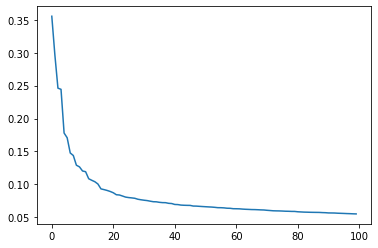

In [5]:
A = adj.tocsc()
D_out = sp.diags(A.transpose().sum(
    axis=0).tolist(), [0]).tocsc()
D_in = sp.diags(A.sum(axis=0).tolist(), [0]).tocsc()
Dbar = (D_in + D_out)
d = sqrtinvdiag(Dbar)
normA = d * A * d
size = A.shape[0]
H = (A-A.transpose()) * 1j
H_abs = np.abs(H)
D_abs_inv = sp.diags(1/np.array(H_abs.sum(1))[:, 0])
D_abs_inv.data[np.isinf(D_abs_inv.data)] = 0.0
H_rw = D_abs_inv.dot(H)
_, s, _ = sp.linalg.svds(H_rw, 100)
eigens = s[list(np.arange(99,-1,-1))]
eigengaps = eigens[:-1] - eigens[1:]
print(np.argsort(-eigengaps))
print(eigengaps)
plt.plot(eigens)
plt.show()
# choose K = 20

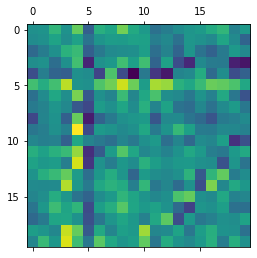

5

In [9]:
num_clusters = 20
u, s, vt = sp.linalg.svds(H_rw, num_clusters)
features_SVD = np.concatenate((np.real(u), np.imag(u)), axis=1)
labels = sl.KMeans(n_clusters=num_clusters).fit_predict(features_SVD)
# A = torch.FloatTensor(A.toarray())
P = torch.zeros(labels.shape[0], num_clusters).to(A.device)
for k in range(num_clusters):
    P[labels == k, k] = 1
flow_mat = np.ones([num_clusters, num_clusters])*0.5
for k in range(num_clusters-1):
    for l in range(k+1, num_clusters):
        w_kl = torch.matmul(P[:, k], torch.matmul(A, P[:, l])).item()
        w_lk = torch.matmul(P[:, l], torch.matmul(A, P[:, k])).item()
        if (w_kl + w_lk) > 0:
            flow_mat[k, l] = w_kl/(w_kl + w_lk)
            flow_mat[l, k] = w_lk/(w_kl + w_lk)
plt.matshow(flow_mat)
plt.show()
np.sum(flow_mat>0.7)